In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
from sklearn.model_selection import train_test_split
import glob
import os
from mpl_toolkits.mplot3d import Axes3D

## The idea for this project and preparation of data is taken from the paper at 

## https://ml4physicalsciences.github.io/2024/files/NeurIPS_ML4PS_2024_122.pdf

## We used a small simulated sample of halos and subhalos from the TNG project at https://www.tng-project.org/data/. 
### The exact dataset is the Groupcat at Snapshot 0 provided at https://www.tng-project.org/data/downloads/TNG50-1/

### Our data is a Group Catalog of 'Groups' (i.e halos), and 'Subhalos' which belong to these groups. In the TNG simulations-
### The Group fields are derived with a standard friends-of-friends (FoF) algorithm with linking length 𝑏=0.2. The FoF algorithm is run on the dark matter particles, and the other types (gas, stars, BHs) are attached to the same groups as their nearest DM particle.
### The Subhalo fields are derived with the Subfind algorithm, with modifications to add additional baryonic properties to each subhalo entry.
### Subhalo clusters are associated to halos. The first (most massive) subgroup of each halo is the "Primary Subgroup" or "Central Subgroup".

In [2]:
# Path to the data folder
data_path = "Mod7_data/data"
file_pattern = os.path.join(data_path, "fof_subhalo_tab_000.*.hdf5") 
files = sorted(glob.glob(file_pattern))

# Loop through all files
# for file in files:
#     with h5py.File(file, 'r') as f:
#         print(f"File: {file}")

In [3]:
with h5py.File(files[0], 'r') as f: #files[0] = Mod7_data/data/fof_subhalo_tab_000.0.hdf5 (1st data file)
    data = f['Subhalo'].keys() 
    group = f['Group'].keys()
    print(data)
    print(group)

<KeysViewHDF5 ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'SubhaloStarMetallicityHalfRad', 'SubhaloStarMetallicityM

In [5]:
h = 0.6774

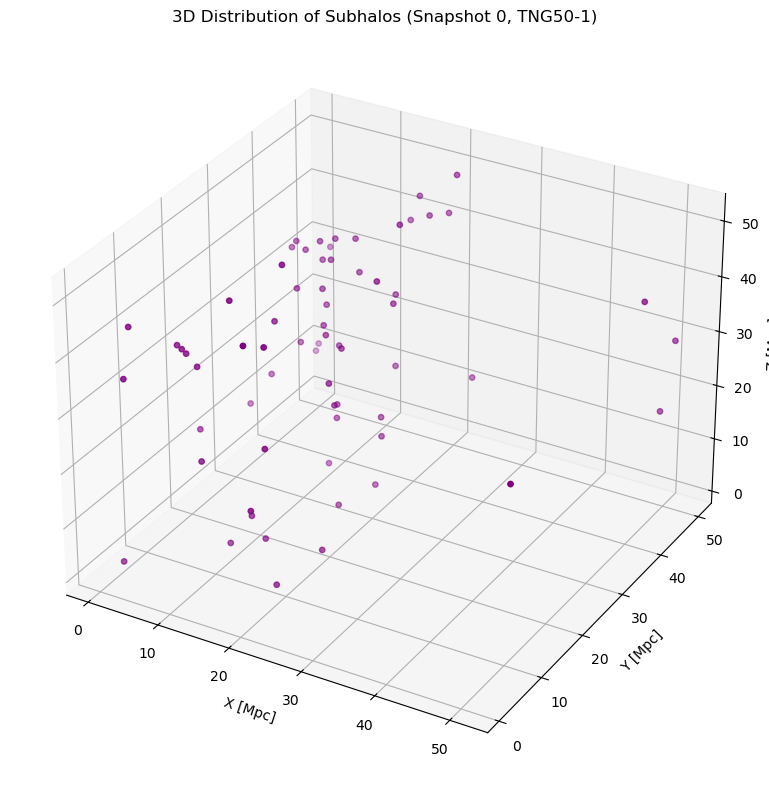

In [6]:
for file in files:
    with h5py.File(file, 'r') as f:
        pos = f['Subhalo']['SubhaloPos'][:] / (h*1e3) # shape: (N, 3)

# # 2D projection
# # if pos.shape[0] > 10000:
# #     idx = np.random.choice(pos.shape[0], 10000, replace=False)
# #     pos = pos[idx]

# Plot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=15, c='purple')

ax.set_xlabel('X [Mpc]')
ax.set_ylabel('Y [Mpc]')
ax.set_zlabel('Z [Mpc]')
ax.set_title('3D Distribution of Subhalos (Snapshot 0, TNG50-1)')
plt.tight_layout()
plt.show()


### Loading Subhalo and Group fields from our data files to be used later


In [7]:
fields = [
    'SubhaloMassType',              # [N, 6] → use stellar mass (index 4)
    'SubhaloVmax',                  # [N]
    'SubhaloHalfmassRadType',      # [N, 6] → use stellar (index 4)
    'SubhaloPos',                  # [N, 3] → for edge creation (x.y.z)
    'SubhaloGrNr',                 # [N] → FoF group
    'SubhaloStellarPhotometrics',
    'SubhaloVel'
]

halo_fields = ['GroupFirstSub', 'Group_M_Crit200']  # can add more like GroupMass, GroupPos, etc.

In [8]:
all_data = {field: [] for field in fields}

for file in files:
    with h5py.File(file, 'r') as f:
        for field in fields:
            all_data[field].append(f['Subhalo'][field][:])

# Concatenate
for field in fields:
    all_data[field] = np.concatenate(all_data[field], axis=0)

all_data_halo = {field: [] for field in halo_fields}

for file in files:
    with h5py.File(file, 'r') as f:
        for field in halo_fields:
            all_data_halo[field].append(f['Group'][field][:])

# Concatenate across all files
for field in halo_fields:
    all_data_halo[field] = np.concatenate(all_data_halo[field], axis=0)

In [14]:
all_data['SubhaloMassType'] #divided by types 
print(len(all_data_halo['GroupFirstSub']))

35412


### Our target data is the log of halo mass in units of $M_{sun}$. This is taken from the DM candidate mass as denoted by type 1 in the IllustrisTNG simulation site

In [14]:
subhalo_grnr = all_data['SubhaloGrNr']        # shape (N,)
group_firstsub = all_data_halo['GroupFirstSub']  # shape (N_groups,)
# group_mass = all_data_halo['Group_M_Crit200']  # shape: (N_groups,)

subhalo_halomass = all_data['SubhaloMassType'][:, 1]  # DM mass only
subhalo_loghalomass = np.log10(subhalo_halomass / h) + 10


# Get subhalo indices (0...N-1)
subhalo_indices = np.arange(len(subhalo_grnr))

# Lookup the central subhalo ID for each subhalo's FoF group
central_ids = group_firstsub[subhalo_grnr]

# Compare: is this subhalo the central?
is_central = (subhalo_indices == central_ids).astype(int)  # 1 = central, 0 = satellite


## Define feature matrix: 
### Selected type 4 for considering only galaxies 

    1. Stellar mass of galaxy  
    2. Its half mass radius - Comoving radius containing half of the mass of this Subhalo
    3. Maximum value of the spherically-averaged rotation curve.
    4. Whether object is central or a satellite galaxy
    5. Photometric color indices

### It is to be noted that many other features used in the original paper, like distance of galaxies from center and surface rightness haven't been included here. Also, some form of normalisation is carried out in that paper which we didn't include here

In [60]:
stellar_mass = all_data['SubhaloMassType'][:, 4] 
log_stellar_mass = np.log10(stellar_mass / h + 1e-8) + 10

half_mass_rad = all_data['SubhaloHalfmassRadType'][:, 4]
log_half_mass_rad = np.log10(half_mass_rad + 1e-8)

vmax = all_data['SubhaloVmax']
log_vmax = np.log10(vmax + 1e-8)

photometry = all_data['SubhaloStellarPhotometrics']  # shape: (N, 8)
velocity = all_data['SubhaloVel']                    # shape: (N, 3)

photometry = all_data['SubhaloStellarPhotometrics']
U = photometry[:, 0]
B = photometry[:, 1]
V = photometry[:, 2]
g = photometry[:, 4]
r = photometry[:, 5]
i = photometry[:, 6]
z = photometry[:, 7]

u_minus_b = U - B
b_minus_v = B - V
g_minus_r = g - r
r_minus_i = r - i
i_minus_z = i - z

# Cut: stellar mass > 1e5 and halfmass radius > 0 and Vmax > 0 (take some massive galaxies)
mask = (log_stellar_mass > 5) & (vmax > 0) & (half_mass_rad > 0)

# Apply mask
positions = all_data['SubhaloPos'][mask]
features = np.stack([
    log_stellar_mass[mask],
    log_vmax[mask],
    log_half_mass_rad[mask],
    u_minus_b[mask],
    b_minus_v[mask],
    g_minus_r[mask],
    r_minus_i[mask],
    i_minus_z[mask]
], axis=1)  # shape: (N, 3)
is_central_masked = is_central[mask].reshape(-1, 1)  # shape: (N, 1)
features = np.hstack([features, is_central_masked])

print(f"Number of nodes after cut: {positions.shape[0]}")

Number of nodes after cut: 210


### Selecting nearest neighbors of galaxies from sklearn to establish edges

#### We have not added any edge features to keep it simple; can use comoving velocities etc to establish relation between galaxies

In [61]:
from sklearn.neighbors import NearestNeighbors
import torch
from torch_geometric.data import Data

k = 10
knn = NearestNeighbors(n_neighbors=k+1).fit(positions)
_, indices = knn.kneighbors(positions)

src = np.repeat(np.arange(len(indices)), k)
dst = indices[:, 1:].flatten()
edge_index = torch.tensor([src, dst], dtype=torch.long)

In [62]:
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(subhalo_loghalomass[mask], dtype=torch.float) #log_halo_mass
#y = torch.tensor(log_stellar_mass[mask], dtype=torch.float)  # or any target

data = Data(x=x, edge_index=edge_index, y=y)

In [63]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class SimpleGNN(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 32)
        self.conv2 = GCNConv(32, 64)
        self.conv3 = GCNConv(64, 32)
        self.out = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = self.out(x).squeeze()
        return x

In [101]:
model = SimpleGNN(in_channels=x.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

# Split into train/test
num_nodes = data.num_nodes
perm = torch.randperm(num_nodes)
split = int(0.8 * num_nodes)
train_mask = perm[:split]
test_mask = perm[split:]

for epoch in range(2000):
    model.train()
    optimizer.zero_grad()
    pred = model(data.x, data.edge_index)
    loss = loss_fn(pred[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        test_loss = loss_fn(pred[test_mask], data.y[test_mask]).item()
        print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}")

Epoch 0, Train Loss: 55.2956, Test Loss: 55.3672
Epoch 500, Train Loss: 0.1304, Test Loss: 0.1132
Epoch 1000, Train Loss: 0.1014, Test Loss: 0.0915
Epoch 1500, Train Loss: 0.1676, Test Loss: 0.1567


In [102]:
model.eval()
with torch.no_grad():
    predictions = model(data.x, data.edge_index)

## Predicted vs true log halo mass (in units of $M_{sun}$)
### The slope of the scatter plot should have been closer to 1, but our model was over-simplified and data points were less

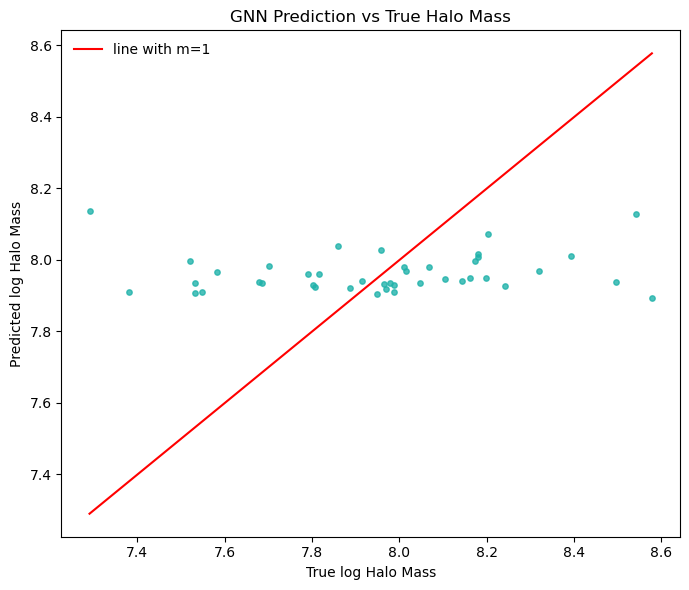

In [119]:
import matplotlib.pyplot as plt

true = data.y[test_mask].cpu().numpy()
pred = predictions[test_mask].cpu().numpy()

plt.figure(figsize=(7, 6))
plt.scatter(true, pred, alpha=0.8, s=15, c='lightseagreen')
plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r-', label = 'line with m=1')
plt.xlabel("True log Halo Mass")
plt.ylabel("Predicted log Halo Mass")
plt.title("GNN Prediction vs True Halo Mass")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [104]:
from sklearn.metrics import r2_score, root_mean_squared_error

r2 = r2_score(true, pred)
rmse = root_mean_squared_error(true, pred)
print(f"R² score: {r2:.4f}")
print(f"RMSE: {rmse:.4f} dex")

R² score: 0.0024
RMSE: 0.2995 dex
